[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mfrashad/text2art/blob/main/text2art.ipynb)

# Setup import

In [ ]:
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button 

%%capture

from google.colab import output
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print(f"GPU check: {ram_gb} MiB available: virtual_memory")

nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  warning_string = f"--> GPU check: ONLY {gpu_memory} MiB available: Please use low quality or low res <--"
  print(warning_string)
  output.eval_js('alert("Warning - low GPU (see message)")')
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")


# this patch applied to fix torchtext dependency 11 Nov 2021
!pip install torch==1.9.0+cu111 torchtext==0.10.0 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch/ -f https://download.pytorch.org/whl/torchvision/

!git clone https://github.com/openai/CLIP
# !pip install taming-transformers
!git clone https://github.com/CompVis/taming-transformers.git
!rm -Rf pixray
!git clone https://github.com/dribnet/pixray
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia==0.6.1
!pip install imageio-ffmpeg   
!pip install einops
!pip install torch-optimizer
!pip install easydict
!pip install braceexpand
!pip install git+https://github.com/pvigier/perlin-numpy
!mkdir -p steps
!mkdir -p models

import sys
sys.path.append("pixray")

  # ClipDraw deps
!pip install svgwrite
!pip install svgpathtools
!pip install cssutils
!pip install numba
!pip install torch-tools
!pip install visdom

!pip install gradio==2.3.7

!git clone https://github.com/BachiLi/diffvg
%cd diffvg
# !ls
!git submodule update --init --recursive
!python setup.py install
%cd ..
  
!mkdir -p steps
!mkdir -p models

result_msg = "setup complete"

import IPython
import os

js_code = f'''
document.querySelector("#output-area").appendChild(document.createTextNode("{result_msg}"));
'''
js_code += '''
for (rule of document.styleSheets[0].cssRules){
  if (rule.selectorText=='body') break
}
rule.style.fontSize = '30px'
'''
display(IPython.display.Javascript(js_code))
print("Ready")

# Generation


In [1]:
import pixray

#@title Manuel

#@title Settings for your run

#@markdown This text prompt is what the computer will try to draw.

#@title Parameters
prompts = "Squid Game by Hwang Dong-hyuk" #@param {type:"string"}

#@markdown you can trade off speed for quality

quality = "normal" #@param ["draft", "normal", "better", "best"]

#@markdown tall or wide?

aspect = "square" #@param ["widescreen", "portrait", "square"]

#@markdown Generating Pixel Arts
drawer = "none" #@param ["none", "vqgan", "pixel", "line_sketch", "clipdraw"]


#@markdown Generating Video
make_video = False #@param {type:"boolean"}

#@markdown Custom Size
custom_size_active = False #@param {type:"boolean"}
width = 800 #@param {type:"integer"}
height = 200 #@param {type:"integer"}

#@markdown Longer Iterations
iterations = 1 #@param {type:"integer"}

#@markdown When you have the settings you want, press the play button on the left.

#@markdown The system will start drawing and show you results as it goes along.

# Simple setup from menu choices

pixray.reset_settings()
pixray.add_settings(prompts=prompts, aspect=aspect, quality=quality, make_video=make_video, iterations=iterations)

if custom_size_active:
  pixray.add_settings(size=(width, height))

if drawer != "none":
  pixray.add_settings(drawer=drawer)

pixray.add_settings(vector_prompts="textoff")

# Optional: you could put extra settings here...
# pixray.add_settings(display_clear=True)

# Apply these settings and run
settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)

ModuleNotFoundError: ignored

In [4]:
#@title UI
import gradio as gr
import torch
import clipit

# Define the main function
def generate(prompt, quality, style, aspect):
    torch.cuda.empty_cache()
    clipit.reset_settings()
    
    use_pixeldraw = (style == 'pixel art')
    use_clipdraw = (style == 'painting')
    clipit.add_settings(prompts=prompt,
                        aspect=aspect,
                        quality=quality,
                        use_pixeldraw=use_pixeldraw,
                        use_clipdraw=use_clipdraw,
                        make_video=True)
  
    settings = clipit.apply_settings()
    clipit.do_init(settings)
    clipit.do_run(settings)

    return 'output.png', 'output.mp4'

# Create the UI
prompt = gr.inputs.Textbox(default="Underwater city", label="Text Prompt")
quality = gr.inputs.Radio(choices=['draft', 'normal', 'better'], label="Quality")
style = gr.inputs.Radio(choices=['image', 'painting','pixel art'], label="Type")
aspect = gr.inputs.Radio(choices=['square', 'widescreen','portrait'], label="Size")

# Launch the demo
iface = gr.Interface(generate, inputs=[prompt, quality, style, aspect], outputs=['image', 'video'], enable_queue=True, live=False)
iface.launch(debug=True)

FileNotFoundError: ignored

# Automatisation

In [3]:
#@title Setup import
!pip install fastapi nest-asyncio pyngrok uvicorn aiofiles python-multipart firebase-admin

     |████████████████████████████████| 745 kB 5.4 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=26facb1824898c4d148ac3f6688f719b93f7a452802a7e6b1bf317d8cf4c79fc
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/

In [ ]:
#@title MailGun function

import requests
def email_results_mailgun(email, prompt):
  
    return requests.post(
        "https://api.mailgun.net/v3/text2art.com/messages",
        auth=("api", "YOUR_API_KEY"),
        files=[("attachment",("output.png", open("output.png", "rb").read() )),
               ("attachment", ("output.mp4", open("output.mp4", "rb").read() ))],
        data={"from": "Text2Art <hello@text2art.com>",
              "to": email,
              "subject": "Your Artwork is ready!",
              "text": f'Your generated arts using the prompt "{prompt}".',
              "html": f'Your generated arts using the prompt <strong>"{prompt}"</strong>.'})

In [ ]:
#@title Watermark image

import random
from PIL import Image, ImageDraw, ImageFont

#Opening Image & Creating New Text Layer
def watermark_image(input_file, output_file):
    img = Image.open(input_file).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    #Creating Text
    text = "Text2Art.com"
    font = ImageFont.load_default()

    #Creating Draw Object
    d = ImageDraw.Draw(txt)

    #Positioning Text
    width, height = img.size 
    textwidth, textheight = d.textsize(text, font)
    x=width-textwidth-1
    y=height-textheight-1

    #Applying Text
    d.text((x,y), text, fill=(255,255,255, 200), font=font)

    #Combining Original Image with Text and Saving
    watermarked = Image.alpha_composite(img, txt)
    watermarked.save(output_file)

In [ ]:
import sys
sys.path.append("clipit")

Please Upload your Firebase credentials json file

In [ ]:
#@title Define generate function
import torch
import clipit
from datetime import datetime

import firebase_admin
from firebase_admin import credentials, firestore, storage

if not firebase_admin._apps:
    cred = credentials.Certificate("YOUR_CREDENTIAL")
    firebase_admin.initialize_app(cred, {
        'storageBucket': 'YOUR_BUCKET_URL'
    })

db = firestore.client()
bucket = storage.bucket()

def generate(doc_id, init_image, prompt, quality, style, aspect, email, public):
    torch.cuda.empty_cache()
    clipit.reset_settings()
    if init_image == '':
        init_image = None
    use_pixeldraw = (style == 'pixel art')
    use_clipdraw = (style == 'painting')
    seed = int(datetime.now().timestamp())
    enforce_smoothness = 50 if use_pixeldraw else 0
    enforce_saturation=1000 if use_pixeldraw else 0
    enforce_smoothness_type='log' if use_pixeldraw else 'default'
    clipit.add_settings(prompts=prompt,
                        init_image=init_image,
                        seed=seed,
                        aspect=aspect,
                        quality=quality,
                        scale=2.5,
                        display_every=7919,
                        use_pixeldraw=use_pixeldraw,
                        use_clipdraw=use_clipdraw,
                        enforce_smoothness=enforce_smoothness,
                        enforce_saturation=enforce_saturation,
                        enforce_smoothness_type=enforce_smoothness_type,
                        make_video=True)
    
    settings = clipit.apply_settings()
    clipit.do_init(settings)
    clipit.do_run(settings)
    watermark_image('output.png', 'output.png')


    image_blob = bucket.blob(f'generated_images/{doc_id}.png')
    image_blob.upload_from_filename('output.png')
    image_blob.make_public()

    video_blob = bucket.blob(f'generated_videos/{doc_id}.mp4')
    video_blob.upload_from_filename('output.mp4')
    video_blob.make_public()

    data = {
        "image": image_blob.public_url,
        "video": video_blob.public_url,
        "seed": seed,
        "prompt": prompt,
        "quality": quality,
        "aspect": aspect,
        "type": style,
        "user": email,
        "likes": 0,
        "public": public,
        "created_at": datetime.now()
    }
    db.collection('generated_images').document(doc_id).set(data)
    #email_results_sendgrid(email, prompt)
    email_results_mailgun(email, prompt)
    db.collection('emails').document(email).set({})

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2220032/45929032 bytes (4.8%)5267456/45929032 bytes (11.5%)8413184/45929032 bytes (18.3%)11444224/45929032 bytes (24.9%)14630912/45929032 bytes (31.9%)17801216/45929032 bytes (38.8%)20914176/45929032 bytes (45.5%)24133632/45929032 bytes (52.5%)27418624/45929032 bytes (59.7%)30482432/45929032 bytes (66.4%)33677312/45929032 bytes (73.3%)36675584/45929032 bytes (79.9%)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 54.5MiB/s]
100%|███████████████████████████████████████| 335M/335M [00:05<00:00, 62.0MiB/s]


Using device: cuda:0
Optimising using: Adam
Using text prompts: ['valorant']
Using seed: 1631366921


0it [00:00, ?it/s]

iter: 0, loss: 1.77756, losses: 0.896446, 0.881113, 0, -0


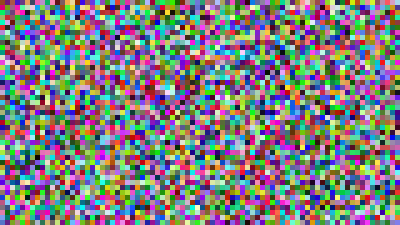

iter: 10, loss: 1.72015, losses: 0.84635, 0.836922, 0.0409631, -0.00408081
iter: 20, loss: 1.69675, losses: 0.829035, 0.8129, 0.0626368, -0.00781748
iter: 30, loss: 1.64905, losses: 0.796871, 0.755306, 0.108576, -0.0117031
iter: 40, loss: 1.66617, losses: 0.793051, 0.763375, 0.124852, -0.015108
iter: 50, loss: 1.66109, losses: 0.785438, 0.748441, 0.145102, -0.0178915
iter: 60, loss: 1.61747, losses: 0.763514, 0.722728, 0.151594, -0.0203671
iter: 70, loss: 1.6243, losses: 0.756159, 0.717041, 0.173703, -0.0226
iter: 80, loss: 1.6517, losses: 0.755481, 0.721403, 0.20054, -0.0257214
iter: 90, loss: 1.63669, losses: 0.746971, 0.709676, 0.208813, -0.0287667
iter: 100, loss: 1.60978, losses: 0.710045, 0.662432, 0.26614, -0.0288405
iter: 110, loss: 1.64724, losses: 0.738359, 0.69756, 0.245333, -0.0340134
iter: 120, loss: 1.66847, losses: 0.74384, 0.705294, 0.254834, -0.0354999
iter: 130, loss: 1.67936, losses: 0.730546, 0.692289, 0.296178, -0.0396517
iter: 140, loss: 1.6723, losses: 0.732378, 

100%|██████████| 350/350 [00:03<00:00, 97.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated  valorant for krysis21dev@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['scenery of a classroom']
Using seed: 1631367441


0it [00:00, ?it/s]

iter: 0, loss: 1.79334, losses: 0.905605, 0.887731


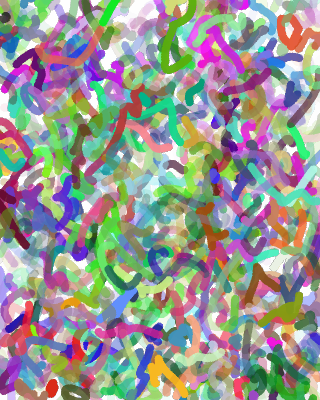

iter: 10, loss: 1.68093, losses: 0.844151, 0.836781
iter: 20, loss: 1.6049, losses: 0.799293, 0.805606
iter: 30, loss: 1.51132, losses: 0.75481, 0.756509
iter: 40, loss: 1.5133, losses: 0.757533, 0.755768
iter: 50, loss: 1.46864, losses: 0.738323, 0.730322
iter: 60, loss: 1.4448, losses: 0.725583, 0.719218
iter: 70, loss: 1.34917, losses: 0.682924, 0.66625
iter: 80, loss: 1.43634, losses: 0.724533, 0.711809
iter: 90, loss: 1.31944, losses: 0.66941, 0.650025
iter: 100, loss: 1.32222, losses: 0.669427, 0.652795
iter: 110, loss: 1.37596, losses: 0.697287, 0.678675
iter: 120, loss: 1.313, losses: 0.665578, 0.647419
iter: 130, loss: 1.30345, losses: 0.659978, 0.643476
iter: 140, loss: 1.2921, losses: 0.656035, 0.636068
iter: 150, loss: 1.37444, losses: 0.69543, 0.679006
iter: 160, loss: 1.29258, losses: 0.657204, 0.635373
iter: 170, loss: 1.36523, losses: 0.691643, 0.67359
iter: 180, loss: 1.36283, losses: 0.691069, 0.671757
iter: 190, loss: 1.34418, losses: 0.683817, 0.660367
iter: 200, lo

100%|██████████| 350/350 [00:05<00:00, 63.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated scenery of a classroom for ntnamn@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['apes painting a mountain']
Using seed: 1631368244


0it [00:00, ?it/s]

iter: 0, loss: 1.83495, losses: 0.921623, 0.913329


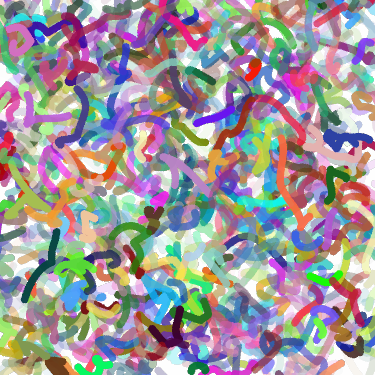

iter: 10, loss: 1.56493, losses: 0.800183, 0.764745
iter: 20, loss: 1.5014, losses: 0.769082, 0.732317
iter: 30, loss: 1.40154, losses: 0.719156, 0.682388
iter: 40, loss: 1.40957, losses: 0.725792, 0.683783
iter: 50, loss: 1.37559, losses: 0.713517, 0.662075
iter: 60, loss: 1.38377, losses: 0.719499, 0.66427
iter: 70, loss: 1.36002, losses: 0.709037, 0.65098
iter: 80, loss: 1.35096, losses: 0.706013, 0.644948
iter: 90, loss: 1.36741, losses: 0.715287, 0.65212
iter: 100, loss: 1.31304, losses: 0.68953, 0.623509
iter: 110, loss: 1.32172, losses: 0.699595, 0.622122
iter: 120, loss: 1.31483, losses: 0.694301, 0.620525
iter: 130, loss: 1.21858, losses: 0.660242, 0.558335
iter: 140, loss: 1.21807, losses: 0.65896, 0.559112
iter: 150, loss: 1.1966, losses: 0.649495, 0.547109
iter: 160, loss: 1.2718, losses: 0.679278, 0.592523
iter: 170, loss: 1.25779, losses: 0.669528, 0.588257
iter: 180, loss: 1.29333, losses: 0.688034, 0.605296
iter: 190, loss: 1.18015, losses: 0.648566, 0.531582
iter: 200,

100%|██████████| 350/350 [00:07<00:00, 49.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated apes painting a mountain for nihaoma8879@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['nuclear explosion Artstation']
Using seed: 1631369036


0it [00:00, ?it/s]

iter: 0, loss: 1.98218, losses: 1.01732, 0.964859


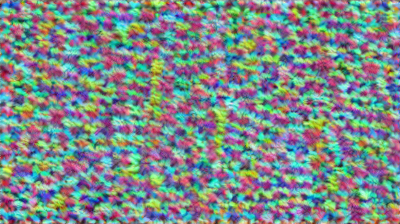

iter: 10, loss: 1.80967, losses: 0.934088, 0.875584
iter: 20, loss: 1.68411, losses: 0.866507, 0.817607
iter: 30, loss: 1.54657, losses: 0.787691, 0.75888
iter: 40, loss: 1.53726, losses: 0.791438, 0.74582
iter: 50, loss: 1.55067, losses: 0.798633, 0.752035
iter: 60, loss: 1.53845, losses: 0.791869, 0.746585
iter: 70, loss: 1.50005, losses: 0.766011, 0.734036
iter: 80, loss: 1.5107, losses: 0.773652, 0.737044
iter: 90, loss: 1.4061, losses: 0.718441, 0.687654
iter: 100, loss: 1.41059, losses: 0.720596, 0.689997
iter: 110, loss: 1.40362, losses: 0.715753, 0.687865
iter: 120, loss: 1.48753, losses: 0.762674, 0.724853
iter: 130, loss: 1.45812, losses: 0.748371, 0.709751
iter: 140, loss: 1.43548, losses: 0.734247, 0.70123
iter: 150, loss: 1.45012, losses: 0.73959, 0.71053
iter: 160, loss: 1.44826, losses: 0.738534, 0.709729
iter: 170, loss: 1.37094, losses: 0.693602, 0.677333
iter: 180, loss: 1.38504, losses: 0.702857, 0.682185
iter: 190, loss: 1.45619, losses: 0.74202, 0.71417
iter: 200, 

100%|██████████| 350/350 [00:05<00:00, 69.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated nuclear explosion Artstation for meorajrul@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['money counter strike']
Using seed: 1631369366


0it [00:00, ?it/s]

iter: 0, loss: 1.86777, losses: 0.938345, 0.929424


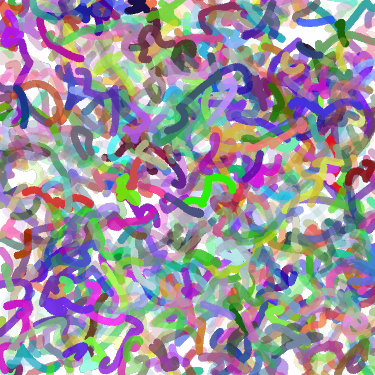

iter: 10, loss: 1.68013, losses: 0.841294, 0.83884
iter: 20, loss: 1.603, losses: 0.810142, 0.792857
iter: 30, loss: 1.49131, losses: 0.75163, 0.739675
iter: 40, loss: 1.50406, losses: 0.752236, 0.751819
iter: 50, loss: 1.49349, losses: 0.751017, 0.74247
iter: 60, loss: 1.4929, losses: 0.748544, 0.744359
iter: 70, loss: 1.4659, losses: 0.733613, 0.732289
iter: 80, loss: 1.43947, losses: 0.724887, 0.714587
iter: 90, loss: 1.39916, losses: 0.703197, 0.695961
iter: 100, loss: 1.37969, losses: 0.695542, 0.684148
iter: 110, loss: 1.45146, losses: 0.729388, 0.722072
iter: 120, loss: 1.41209, losses: 0.713261, 0.698827
iter: 130, loss: 1.42972, losses: 0.720548, 0.709171
iter: 140, loss: 1.3643, losses: 0.688804, 0.675492
iter: 150, loss: 1.42707, losses: 0.720021, 0.707046
iter: 160, loss: 1.40857, losses: 0.711569, 0.696999
iter: 170, loss: 1.34469, losses: 0.677766, 0.666927
iter: 180, loss: 1.38629, losses: 0.700613, 0.685673
iter: 190, loss: 1.38379, losses: 0.701282, 0.682506
iter: 200,

100%|██████████| 350/350 [00:07<00:00, 47.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated money counter strike for nihaoma8879@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['MONEY COUNTER STRIKE']
Using seed: 1631370153


0it [00:00, ?it/s]

iter: 0, loss: 1.86938, losses: 0.940531, 0.928845


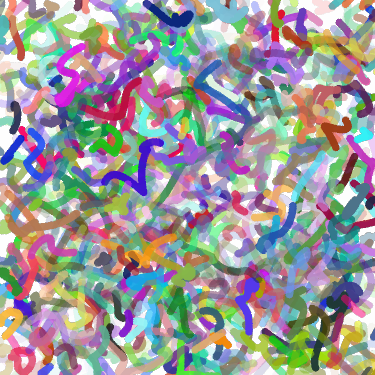

iter: 10, loss: 1.76271, losses: 0.885855, 0.876857
iter: 20, loss: 1.64056, losses: 0.826425, 0.814136
iter: 30, loss: 1.56893, losses: 0.786239, 0.782695
iter: 40, loss: 1.46572, losses: 0.736142, 0.729574
iter: 50, loss: 1.4132, losses: 0.710099, 0.703098
iter: 60, loss: 1.37555, losses: 0.693904, 0.681642
iter: 70, loss: 1.45161, losses: 0.730529, 0.721082
iter: 80, loss: 1.40499, losses: 0.707026, 0.697967
iter: 90, loss: 1.39186, losses: 0.699512, 0.692345
iter: 100, loss: 1.3345, losses: 0.674355, 0.66015
iter: 110, loss: 1.33217, losses: 0.672372, 0.659802
iter: 120, loss: 1.39448, losses: 0.704473, 0.690009
iter: 130, loss: 1.38477, losses: 0.701706, 0.683068
iter: 140, loss: 1.31858, losses: 0.673467, 0.645111
iter: 150, loss: 1.37422, losses: 0.698508, 0.675713
iter: 160, loss: 1.38322, losses: 0.704365, 0.678851
iter: 170, loss: 1.37846, losses: 0.700068, 0.678392
iter: 180, loss: 1.36329, losses: 0.69813, 0.665161
iter: 190, loss: 1.2743, losses: 0.658496, 0.615809
iter: 2

100%|██████████| 350/350 [00:07<00:00, 48.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated MONEY COUNTER STRIKE for nihaoma8879@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Naruto singing Pixelart']
Using seed: 1631370965


0it [00:00, ?it/s]

iter: 0, loss: 0.919428, losses: 0.919428, 0, -0


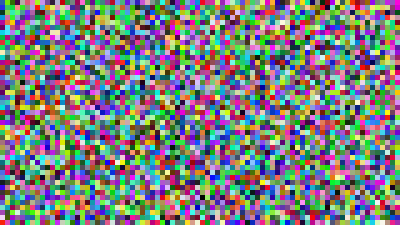

iter: 10, loss: 0.883077, losses: 0.853969, 0.0332053, -0.00409738
iter: 20, loss: 0.844653, losses: 0.76889, 0.0846299, -0.00886689
iter: 30, loss: 0.853612, losses: 0.765205, 0.101008, -0.0126013
iter: 40, loss: 0.842155, losses: 0.700698, 0.158412, -0.0169555
iter: 50, loss: 0.832684, losses: 0.668856, 0.183797, -0.0199688
iter: 60, loss: 0.844957, losses: 0.694442, 0.172256, -0.0217404
iter: 70, loss: 0.836571, losses: 0.635727, 0.225357, -0.0245124
iter: 80, loss: 0.822838, losses: 0.652828, 0.195229, -0.0252191
iter: 90, loss: 0.843595, losses: 0.652551, 0.218892, -0.0278486
iter: 100, loss: 0.839995, losses: 0.631504, 0.241655, -0.0331631
iter: 110, loss: 0.823319, losses: 0.587553, 0.270503, -0.0347358
iter: 120, loss: 0.85022, losses: 0.657152, 0.232321, -0.0392529
iter: 130, loss: 0.848634, losses: 0.588458, 0.305761, -0.0455852
iter: 140, loss: 0.906936, losses: 0.641672, 0.31988, -0.0546163
iter: 150, loss: 0.856862, losses: 0.630063, 0.287536, -0.0607366
iter: 160, loss: 0

100%|██████████| 200/200 [00:02<00:00, 95.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Naruto singing Pixelart for hamzahhamizan18@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['phoenix  Painting Artstation']
Using seed: 1631371180


0it [00:00, ?it/s]

iter: 0, loss: 1.94513, losses: 0.981188, 0.963942


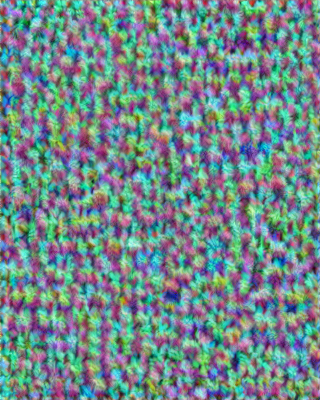

iter: 10, loss: 1.69751, losses: 0.867004, 0.83051
iter: 20, loss: 1.57817, losses: 0.802645, 0.775526
iter: 30, loss: 1.44843, losses: 0.738531, 0.709895
iter: 40, loss: 1.48036, losses: 0.764014, 0.716342
iter: 50, loss: 1.41204, losses: 0.733407, 0.678628
iter: 60, loss: 1.44617, losses: 0.750603, 0.695572
iter: 70, loss: 1.40031, losses: 0.730187, 0.670126
iter: 80, loss: 1.42611, losses: 0.743005, 0.683109
iter: 90, loss: 1.33999, losses: 0.702955, 0.637033
iter: 100, loss: 1.41194, losses: 0.735777, 0.676165
iter: 110, loss: 1.33994, losses: 0.704838, 0.635098
iter: 120, loss: 1.38641, losses: 0.72717, 0.659239
iter: 130, loss: 1.3177, losses: 0.691892, 0.625813
iter: 140, loss: 1.36825, losses: 0.716562, 0.651685
iter: 150, loss: 1.347, losses: 0.70588, 0.641124
iter: 160, loss: 1.31678, losses: 0.693407, 0.623376
iter: 170, loss: 1.34033, losses: 0.704502, 0.635827
iter: 180, loss: 1.29917, losses: 0.682327, 0.616839
iter: 190, loss: 1.33643, losses: 0.702504, 0.633922
iter: 20

100%|██████████| 350/350 [00:07<00:00, 46.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated phoenix  Painting Artstation for kenghzou_yeoh@apecia.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Gold mountain']
Using seed: 1631371528


0it [00:00, ?it/s]

iter: 0, loss: 0.902389, losses: 0.902389


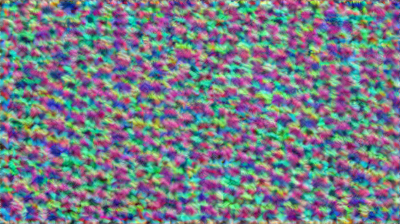

iter: 10, loss: 0.824092, losses: 0.824092
iter: 20, loss: 0.809775, losses: 0.809775
iter: 30, loss: 0.791974, losses: 0.791974
iter: 40, loss: 0.786786, losses: 0.786786
iter: 50, loss: 0.778224, losses: 0.778224
iter: 60, loss: 0.748747, losses: 0.748747
iter: 70, loss: 0.747181, losses: 0.747181
iter: 80, loss: 0.763031, losses: 0.763031
iter: 90, loss: 0.766155, losses: 0.766155
iter: 100, loss: 0.762155, losses: 0.762155
iter: 110, loss: 0.748769, losses: 0.748769
iter: 120, loss: 0.749512, losses: 0.749512
iter: 130, loss: 0.722627, losses: 0.722627
iter: 140, loss: 0.717454, losses: 0.717454
iter: 150, loss: 0.714411, losses: 0.714411
iter: 160, loss: 0.740436, losses: 0.740436
iter: 170, loss: 0.706492, losses: 0.706492
iter: 180, loss: 0.739244, losses: 0.739244
iter: 190, loss: 0.745028, losses: 0.745028
iter: 200, loss: 0.726241, losses: 0.726241
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|██████████| 200/200 [00:03<00:00, 61.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Gold mountain for m.fathyrashad@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Asthetic']
Using seed: 1631371632


0it [00:00, ?it/s]

iter: 0, loss: 0.864731, losses: 0.864731


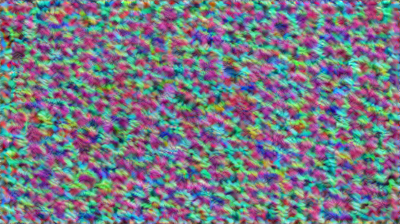

iter: 10, loss: 0.822628, losses: 0.822628
iter: 20, loss: 0.815421, losses: 0.815421
iter: 30, loss: 0.802277, losses: 0.802277
iter: 40, loss: 0.802139, losses: 0.802139
iter: 50, loss: 0.800776, losses: 0.800776
iter: 60, loss: 0.792289, losses: 0.792289
iter: 70, loss: 0.794025, losses: 0.794025
iter: 80, loss: 0.793929, losses: 0.793929
iter: 90, loss: 0.788579, losses: 0.788579
iter: 100, loss: 0.788586, losses: 0.788586
iter: 110, loss: 0.784334, losses: 0.784334
iter: 120, loss: 0.780494, losses: 0.780494
iter: 130, loss: 0.782266, losses: 0.782266
iter: 140, loss: 0.782112, losses: 0.782112
iter: 150, loss: 0.769166, losses: 0.769166
iter: 160, loss: 0.766789, losses: 0.766789
iter: 170, loss: 0.780572, losses: 0.780572
iter: 180, loss: 0.763587, losses: 0.763587
iter: 190, loss: 0.785505, losses: 0.785505
iter: 200, loss: 0.777333, losses: 0.777333
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|██████████| 200/200 [00:03<00:00, 61.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Asthetic for bushrakhan2212002@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Painting of bamboo forest #artstation']
Using seed: 1631372345


0it [00:00, ?it/s]

iter: 0, loss: 1.904, losses: 0.944618, 0.959383


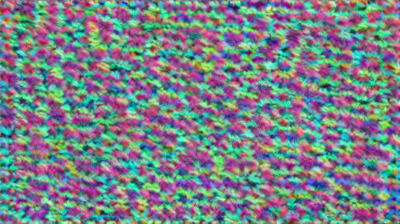

iter: 10, loss: 1.64256, losses: 0.813343, 0.829217
iter: 20, loss: 1.51725, losses: 0.748687, 0.768559
iter: 30, loss: 1.48822, losses: 0.744057, 0.744162
iter: 40, loss: 1.45277, losses: 0.735423, 0.717347
iter: 50, loss: 1.44284, losses: 0.725784, 0.717056
iter: 60, loss: 1.44916, losses: 0.725927, 0.723235
iter: 70, loss: 1.40935, losses: 0.710674, 0.698677
iter: 80, loss: 1.40663, losses: 0.707651, 0.69898
iter: 90, loss: 1.44602, losses: 0.725949, 0.720069
iter: 100, loss: 1.40984, losses: 0.705154, 0.704687
iter: 110, loss: 1.40817, losses: 0.702647, 0.705523
iter: 120, loss: 1.39691, losses: 0.700324, 0.696588
iter: 130, loss: 1.37356, losses: 0.687078, 0.686478
iter: 140, loss: 1.39843, losses: 0.696298, 0.702129
iter: 150, loss: 1.36154, losses: 0.687838, 0.673702
iter: 160, loss: 1.35182, losses: 0.678984, 0.672838
iter: 170, loss: 1.38376, losses: 0.693999, 0.689764
iter: 180, loss: 1.36542, losses: 0.684748, 0.680672
iter: 190, loss: 1.40212, losses: 0.706242, 0.695878
ite

100%|██████████| 350/350 [00:05<00:00, 59.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Painting of bamboo forest #artstation for m.fathyrashad@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Painting of earth burning Trending  Artstation']
Using seed: 1631372911


0it [00:00, ?it/s]

iter: 0, loss: 1.9167, losses: 0.978897, 0.9378


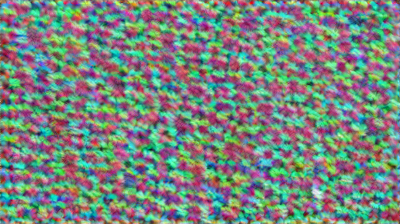

iter: 10, loss: 1.71482, losses: 0.885055, 0.829769
iter: 20, loss: 1.65738, losses: 0.860984, 0.796398
iter: 30, loss: 1.58763, losses: 0.829052, 0.758581
iter: 40, loss: 1.58654, losses: 0.826551, 0.759985
iter: 50, loss: 1.52198, losses: 0.788205, 0.73377
iter: 60, loss: 1.55257, losses: 0.810979, 0.74159
iter: 70, loss: 1.54849, losses: 0.807156, 0.741337
iter: 80, loss: 1.52862, losses: 0.79969, 0.728931
iter: 90, loss: 1.48795, losses: 0.770788, 0.717159
iter: 100, loss: 1.47139, losses: 0.758426, 0.712963
iter: 110, loss: 1.46631, losses: 0.756842, 0.709465
iter: 120, loss: 1.47045, losses: 0.763967, 0.706487
iter: 130, loss: 1.41774, losses: 0.728198, 0.689544
iter: 140, loss: 1.46891, losses: 0.755369, 0.713536
iter: 150, loss: 1.48085, losses: 0.768583, 0.712268
iter: 160, loss: 1.45829, losses: 0.754715, 0.703579
iter: 170, loss: 1.43316, losses: 0.737432, 0.695729
iter: 180, loss: 1.44927, losses: 0.748321, 0.700953
iter: 190, loss: 1.46645, losses: 0.759012, 0.707441
iter:

100%|██████████| 350/350 [00:05<00:00, 58.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Painting of earth burning Trending  Artstation for m.fathyrashad@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Painting of falling meteor in space Artstation']
Using seed: 1631373401


0it [00:00, ?it/s]

iter: 0, loss: 2.02426, losses: 1.02631, 0.997955


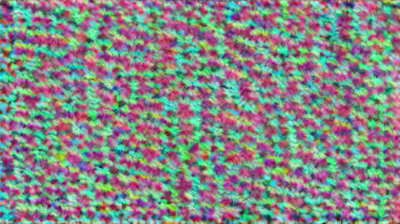

iter: 10, loss: 1.84575, losses: 0.936894, 0.908859
iter: 20, loss: 1.67538, losses: 0.851154, 0.824223
iter: 30, loss: 1.57974, losses: 0.802218, 0.777521
iter: 40, loss: 1.556, losses: 0.785031, 0.770971
iter: 50, loss: 1.48915, losses: 0.746871, 0.742279
iter: 60, loss: 1.55279, losses: 0.789324, 0.76347
iter: 70, loss: 1.53648, losses: 0.781755, 0.754725
iter: 80, loss: 1.46601, losses: 0.744377, 0.721636
iter: 90, loss: 1.51999, losses: 0.76914, 0.750847
iter: 100, loss: 1.46966, losses: 0.747058, 0.722604
iter: 110, loss: 1.4878, losses: 0.757247, 0.73055
iter: 120, loss: 1.46811, losses: 0.74646, 0.721652
iter: 130, loss: 1.47422, losses: 0.745233, 0.728985
iter: 140, loss: 1.47053, losses: 0.752861, 0.717671
iter: 150, loss: 1.47774, losses: 0.747446, 0.730293
iter: 160, loss: 1.46049, losses: 0.739541, 0.720949
iter: 170, loss: 1.45783, losses: 0.736865, 0.72097
iter: 180, loss: 1.45848, losses: 0.741493, 0.716987
iter: 190, loss: 1.40869, losses: 0.716256, 0.692434
iter: 200,

100%|██████████| 350/350 [00:05<00:00, 64.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Painting of falling meteor in space Artstation for m.fathyrashad@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Global warming  Artstation']
Using seed: 1631373820


0it [00:00, ?it/s]

iter: 0, loss: 1.91739, losses: 0.947136, 0.970257


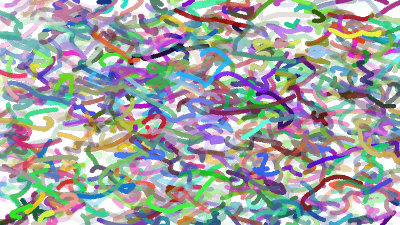

iter: 10, loss: 1.79696, losses: 0.882043, 0.914914
iter: 20, loss: 1.70994, losses: 0.838976, 0.870964
iter: 30, loss: 1.65716, losses: 0.821424, 0.835741
iter: 40, loss: 1.61085, losses: 0.802633, 0.808219
iter: 50, loss: 1.57866, losses: 0.793486, 0.785172
iter: 60, loss: 1.55191, losses: 0.778625, 0.773287
iter: 70, loss: 1.55137, losses: 0.777862, 0.773508
iter: 80, loss: 1.51771, losses: 0.761921, 0.755791
iter: 90, loss: 1.51008, losses: 0.760445, 0.749631
iter: 100, loss: 1.50085, losses: 0.753508, 0.747344
iter: 110, loss: 1.4831, losses: 0.747208, 0.735895
iter: 120, loss: 1.42988, losses: 0.721974, 0.707911
iter: 130, loss: 1.41534, losses: 0.715241, 0.700103
iter: 140, loss: 1.50022, losses: 0.759301, 0.740916
iter: 150, loss: 1.47029, losses: 0.744323, 0.725964
iter: 160, loss: 1.43192, losses: 0.723649, 0.708266
iter: 170, loss: 1.42465, losses: 0.719802, 0.704849
iter: 180, loss: 1.47325, losses: 0.74419, 0.729061
iter: 190, loss: 1.41029, losses: 0.713854, 0.696435
iter

100%|██████████| 350/350 [00:05<00:00, 60.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Global warming  Artstation for m.fathyrashad@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Painting of refugee in war  Artstation']
Using seed: 1631374715


0it [00:00, ?it/s]

iter: 0, loss: 1.97628, losses: 0.998302, 0.977976


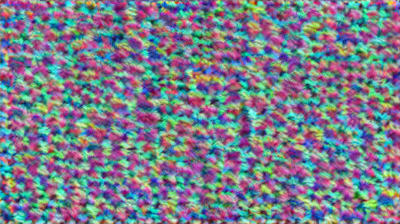

iter: 10, loss: 1.77938, losses: 0.892845, 0.886536
iter: 20, loss: 1.65414, losses: 0.827577, 0.826564
iter: 30, loss: 1.60201, losses: 0.808347, 0.793667
iter: 40, loss: 1.59222, losses: 0.800541, 0.791676
iter: 50, loss: 1.52639, losses: 0.766322, 0.760063
iter: 60, loss: 1.52387, losses: 0.768806, 0.755063
iter: 70, loss: 1.5179, losses: 0.766444, 0.751454
iter: 80, loss: 1.48272, losses: 0.744741, 0.737975
iter: 90, loss: 1.47441, losses: 0.745757, 0.72865
iter: 100, loss: 1.47521, losses: 0.738347, 0.736867
iter: 110, loss: 1.47067, losses: 0.744329, 0.726337
iter: 120, loss: 1.42496, losses: 0.72225, 0.702706
iter: 130, loss: 1.45384, losses: 0.733153, 0.720688
iter: 140, loss: 1.42747, losses: 0.722535, 0.704933
iter: 150, loss: 1.39226, losses: 0.708176, 0.684086
iter: 160, loss: 1.43324, losses: 0.722475, 0.710764
iter: 170, loss: 1.44782, losses: 0.727648, 0.720167
iter: 180, loss: 1.384, losses: 0.70132, 0.682677
iter: 190, loss: 1.4325, losses: 0.726302, 0.706197
iter: 200

100%|██████████| 350/350 [00:05<00:00, 58.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Painting of refugee in war  Artstation for m.fathyrashad@gmail.com
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from models/vqgan_imagenet_f16_16384.ckpt
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Sky full of falling stars Artstation']
Using seed: 1631375843


0it [00:00, ?it/s]

iter: 0, loss: 1.91701, losses: 0.967604, 0.949409


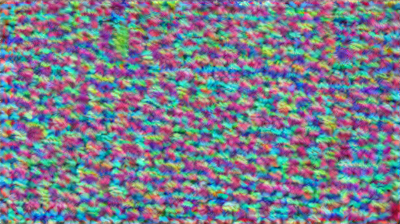

iter: 10, loss: 1.78863, losses: 0.914005, 0.874624
iter: 20, loss: 1.72675, losses: 0.885833, 0.840914
iter: 30, loss: 1.67174, losses: 0.862245, 0.809494
iter: 40, loss: 1.57118, losses: 0.815225, 0.755959
iter: 50, loss: 1.55671, losses: 0.804405, 0.752302
iter: 60, loss: 1.57161, losses: 0.805275, 0.766332
iter: 70, loss: 1.56484, losses: 0.801754, 0.763082
iter: 80, loss: 1.53884, losses: 0.791059, 0.747781
iter: 90, loss: 1.49417, losses: 0.76094, 0.733225
iter: 100, loss: 1.49531, losses: 0.763981, 0.731327
iter: 110, loss: 1.50424, losses: 0.767909, 0.736335
iter: 120, loss: 1.51958, losses: 0.77698, 0.7426
iter: 130, loss: 1.50219, losses: 0.764142, 0.738052
iter: 140, loss: 1.49126, losses: 0.763564, 0.7277
iter: 150, loss: 1.50962, losses: 0.77198, 0.737644
iter: 160, loss: 1.46008, losses: 0.747562, 0.712517
iter: 170, loss: 1.45498, losses: 0.746871, 0.708108
iter: 180, loss: 1.54586, losses: 0.788851, 0.757009
iter: 190, loss: 1.50349, losses: 0.770935, 0.732559
iter: 200

100%|██████████| 350/350 [00:05<00:00, 59.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Sky full of falling stars Artstation for m.fathyrashad@gmail.com


100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 62.5MiB/s]


Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Deep sea fishes #pixelart']
Using seed: 1631376432


0it [00:00, ?it/s]

iter: 0, loss: 2.80006, losses: 0.998, 0.899528, 0.902529, 0, -0


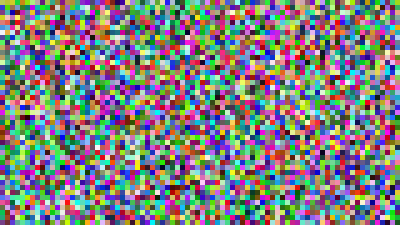

iter: 10, loss: 2.64148, losses: 0.965144, 0.819978, 0.828024, 0.0321351, -0.00380483
iter: 20, loss: 2.51608, losses: 0.925726, 0.765675, 0.770959, 0.0613005, -0.00758498
iter: 30, loss: 2.36191, losses: 0.840563, 0.716011, 0.705389, 0.111174, -0.0112212
iter: 40, loss: 2.37758, losses: 0.850156, 0.709268, 0.708682, 0.123898, -0.0144265
iter: 50, loss: 2.3883, losses: 0.840908, 0.713606, 0.706721, 0.144949, -0.0178794
iter: 60, loss: 2.38233, losses: 0.830858, 0.700258, 0.696721, 0.175498, -0.0210029
iter: 70, loss: 2.30994, losses: 0.785556, 0.668055, 0.651345, 0.229323, -0.0243434
iter: 80, loss: 2.37457, losses: 0.817185, 0.687364, 0.675064, 0.222628, -0.0276681
iter: 90, loss: 2.3833, losses: 0.810865, 0.692539, 0.68026, 0.230653, -0.0310152
iter: 100, loss: 2.28913, losses: 0.754148, 0.6559, 0.638885, 0.274187, -0.0339857
iter: 110, loss: 2.36714, losses: 0.795413, 0.67829, 0.664978, 0.265881, -0.0374195
iter: 120, loss: 2.29083, losses: 0.745225, 0.647482, 0.623588, 0.315621, -0

100%|██████████| 500/500 [00:06<00:00, 82.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Deep sea fishes #pixelart for m.fathyrashad@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Desert temple #pixelart']
Using seed: 1631379468


0it [00:00, ?it/s]

iter: 0, loss: 2.86178, losses: 0.995432, 0.918206, 0.948139, 0, -0


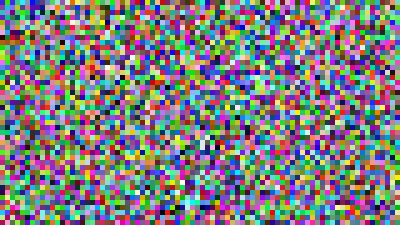

iter: 10, loss: 2.65664, losses: 0.948724, 0.831039, 0.840647, 0.0402595, -0.00402742
iter: 20, loss: 2.5791, losses: 0.913788, 0.796731, 0.814007, 0.0619277, -0.00735546
iter: 30, loss: 2.52579, losses: 0.879295, 0.772825, 0.785154, 0.099673, -0.0111617
iter: 40, loss: 2.45592, losses: 0.854862, 0.743347, 0.744708, 0.126577, -0.0135733
iter: 50, loss: 2.4211, losses: 0.837284, 0.723882, 0.727294, 0.148886, -0.0162431
iter: 60, loss: 2.39617, losses: 0.822666, 0.703227, 0.705974, 0.183653, -0.019351
iter: 70, loss: 2.42274, losses: 0.821785, 0.705605, 0.713454, 0.203923, -0.0220318
iter: 80, loss: 2.3926, losses: 0.804075, 0.686107, 0.691539, 0.235266, -0.0243921
iter: 90, loss: 2.31298, losses: 0.751533, 0.660057, 0.652989, 0.27496, -0.0265601
iter: 100, loss: 2.3891, losses: 0.782347, 0.681727, 0.686485, 0.266955, -0.0284143
iter: 110, loss: 2.37228, losses: 0.786015, 0.678607, 0.674538, 0.262973, -0.0298529
iter: 120, loss: 2.35841, losses: 0.764385, 0.668929, 0.662699, 0.295793, -0

100%|██████████| 500/500 [00:06<00:00, 80.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Desert temple #pixelart for m.fathyrashad@gmail.com
Using device: cuda:0
Optimising using: Adam
Using text prompts: ['Medieval kingdom in fantasy videogame #pixelart']
Using seed: 1631380365


0it [00:00, ?it/s]

iter: 0, loss: 2.86872, losses: 1.00333, 0.930705, 0.934681, 0, -0


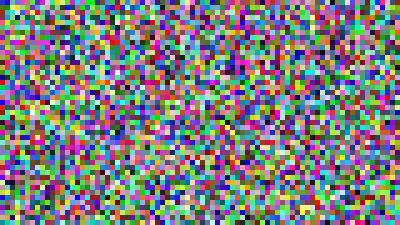

iter: 10, loss: 2.71407, losses: 0.953444, 0.86192, 0.869894, 0.0327056, -0.00389109
iter: 20, loss: 2.57569, losses: 0.904329, 0.801233, 0.810879, 0.0667163, -0.00746464
iter: 30, loss: 2.50871, losses: 0.87019, 0.779682, 0.781287, 0.0881834, -0.0106303
iter: 40, loss: 2.4828, losses: 0.857213, 0.758231, 0.765787, 0.115199, -0.0136312
iter: 50, loss: 2.43499, losses: 0.833987, 0.734452, 0.741435, 0.141674, -0.0165585
iter: 60, loss: 2.45022, losses: 0.830956, 0.730547, 0.733725, 0.17434, -0.0193461
iter: 70, loss: 2.42769, losses: 0.812391, 0.726648, 0.72787, 0.182197, -0.0214158
iter: 80, loss: 2.43402, losses: 0.814304, 0.72248, 0.725145, 0.195131, -0.0230382
iter: 90, loss: 2.41639, losses: 0.790623, 0.700048, 0.702347, 0.24951, -0.0261411
iter: 100, loss: 2.36618, losses: 0.76295, 0.685952, 0.678307, 0.266095, -0.0271284
iter: 110, loss: 2.39427, losses: 0.761523, 0.683658, 0.674659, 0.304659, -0.0302333
iter: 120, loss: 2.41363, losses: 0.753141, 0.683062, 0.672473, 0.338536, -0.

100%|██████████| 500/500 [00:06<00:00, 82.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Generated Medieval kingdom in fantasy videogame #pixelart for m.fathyrashad@gmail.com


In [ ]:
#@title Worker
import firebase_admin
from firebase_admin import credentials, storage, firestore
import time
from datetime import datetime


transaction = db.transaction()

@firestore.transactional
def claim_task(transaction, queue_objects_ref):
    # query firestore
    queue_objects = queue_objects_ref.stream(transaction=transaction)

    # pull the document from the iterable
    next_item = None
    for doc in queue_objects:
        next_item = doc

    # if queue is empty return status code of 2
    if not next_item:
        return {"status": 2}


    # get information from the document 
    next_item_data = next_item.to_dict()
    next_item_data["status"] = 0
    next_item_data['id'] = next_item.id

    # delete the document and return the information
    transaction.delete(next_item.reference)
    return next_item_data

# initialize query
queue_objects_ref = (
    db.collection("queue")
    .order_by("created_at", direction="ASCENDING")
    .limit(1)
)

transaction_attempts = 0
while True:
    try:
        # apply transaction
        next_item_data = claim_task(transaction, queue_objects_ref)
        if next_item_data['status'] == 0:
            generate(next_item_data['id'],
                     next_item_data['init_image'],
                     next_item_data['prompt'],
                     next_item_data['quality'],
                     next_item_data['type'],
                     next_item_data['aspect'],
                     next_item_data['email'],
                     next_item_data['public'])
            print(f"Generated {next_item_data['prompt']} for {next_item_data['email']}")

    except Exception as e:
        print(f"Could not apply transaction. Error: {e}")
        time.sleep(5)
        transaction_attempts += 1
        if transaction_attempts > 20:
            db.collection("errors").add({
                "exception": f"Could not apply artifaication claim transaction. Error: {e}",
                "location": "Claim artifaication",
                "time": str(datetime.now())
            })
            exit()